# Sentiment Classification on Tweets About Apple and Google Products

#### By Jake Oddi

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [59]:
import nltk
from nltk.corpus import stopwords
from nltk.collections import *
from nltk import FreqDist, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import string
import re

In [210]:
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
df = pd.read_csv('tweet_product_company.csv', engine = 'python')

## Data Understanding

In [228]:
df.shape

(9093, 6)

In [10]:
df.head()

,text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     9092 non-null   object
 1   product  3291 non-null   object
 2   emotion  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [16]:
df['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

In [17]:
df['emotion'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [48]:
gb = df.groupby('product')['emotion'].value_counts()
gb

product                          emotion                           
Android                          Positive emotion                       69
                                 Negative emotion                        8
                                 No emotion toward brand or product      1
Android App                      Positive emotion                       72
                                 Negative emotion                        8
                                 No emotion toward brand or product      1
Apple                            Positive emotion                      543
                                 Negative emotion                       95
                                 No emotion toward brand or product     21
                                 I can't tell                            2
Google                           Positive emotion                      346
                                 Negative emotion                       68
                                

<AxesSubplot:title={'center':'Tweet Emotion Frequency by Product'}, xlabel='Product/Company', ylabel='Frequency'>

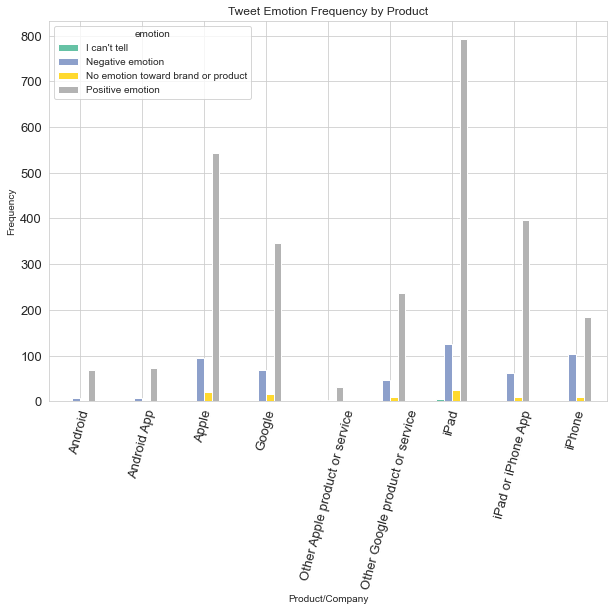

In [184]:
gb.unstack(level=1).plot(kind='bar', 
                         figsize = (10,7), 
                         fontsize = 13, 
                         rot = 75,
                         ylabel = 'Frequency',
                         xlabel = 'Product/Company',
                         title = 'Tweet Emotion Frequency by Product',
                         colormap = 'Set2'
                        )

## Data Cleaning

In [8]:
df.rename(columns = {'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'product', 
                     'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace = True)

In [229]:
df = df[df['emotion'] != "I can't tell"]

In [197]:
df['text'] = df['text'].astype(str)

In [189]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

In [198]:
# Tokenize

df['tokens'] = df['text'].apply(lambda x: nltk.regexp_tokenize(x, pattern))

In [213]:
# Make sure tokens are lowercase

df['tokens'] = df['tokens'].apply(lambda x: [i.lower() for i in x])

In [212]:
# Create Stopwords list`

stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += list(range(0,10))   

In [214]:
# Filter for stopwords

df['tokens'] = df['tokens'].apply(lambda x: [i for i in x if i not in stopwords_list ])

## Feature Engineering

In [ ]:
# Create new column indicating whether tweet is about apple or google

df['split_products'] = df['product'].apply(lambda x: x.split(' ') if type(x) != float else ['nan'])

ag_list = []
for i in range(len(df['split_products'])):
    if any(x in ['Google', 'Android'] for x in df['split_products'][i]):
        ag_list.append('google')
    elif any(x in ['Apple', 'iPad', 'iPhone'] for x in df['split_products'][i]):
        ag_list.append('apple')
    else:
        ag_list.append('neither')
ag_list
df['a_or_g'] = ag_list

In [142]:
ag_gb = df.groupby('a_or_g')['emotion'].value_counts()
ag_gb

a_or_g   emotion                           
apple    Positive emotion                      1949
         Negative emotion                       388
         No emotion toward brand or product      65
         I can't tell                             7
google   Positive emotion                       723
         Negative emotion                       131
         No emotion toward brand or product      26
         I can't tell                             2
neither  No emotion toward brand or product    5298
         Positive emotion                       306
         I can't tell                           147
         Negative emotion                        51
Name: emotion, dtype: int64

In [220]:
' '.join(['a', 'b'])

'a b'

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
#

In [248]:
df['tokens_linked']=[" ".join(token) for token in df['tokens'].values]

<ipython-input-248-f2d6a7b39d4f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens_linked']=[" ".join(token) for token in df['tokens'].values]


## EDA 2

<AxesSubplot:title={'center':'Tweet Emotion Frequency by Company'}, xlabel='Company', ylabel='Frequency'>

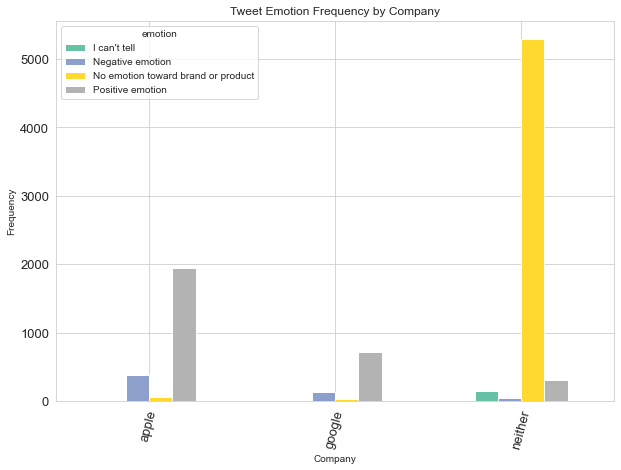

In [185]:
ag_gb.unstack(level = 1).plot(kind = 'bar',
                             figsize = (10,7), 
                             fontsize = 13, 
                             rot = 75,
                             ylabel = 'Frequency',
                             xlabel = 'Company',
                             title = 'Tweet Emotion Frequency by Company',
                             colormap = 'Set2'
                             )

[Text(0.5, 0, 'Company'),
 Text(0, 0.5, 'Relative Frequency'),
 Text(0.5, 1.0, 'Company Mention in Tweet Frequency')]

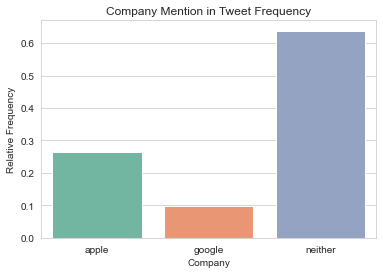

In [186]:
c_freq = sns.barplot(x = df['a_or_g'].value_counts(normalize = True).index, 
                    y = df['a_or_g'].value_counts(normalize = True).values,
                    order = ['apple', 'google', 'neither'],
                    palette = 'Set2'
                    )
c_freq.set(xlabel = 'Company', 
           ylabel = 'Relative Frequency',
           title = 'Company Mention in Tweet Frequency'
          )

## Modeling

In [230]:
df.head()

,text,product,emotion,a_or_g,split_products,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,apple,[iPhone],"[wesley, g, iphone, hrs, tweeting, rise, austi..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,apple,"[iPad, or, iPhone, App]","[jessedee, know, fludapp, awesome, ipad, iphon..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,apple,[iPad],"[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,apple,"[iPad, or, iPhone, App]","[sxsw, hope, year's, festival, crashy, year's,..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,google,[Google],"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


In [249]:
data = df['tokens_linked']
target = df['emotion']

In [250]:
X_train, X_test, y_train, y_test = train_test_split(data, target)

In [241]:
total_vocab = set()
for i in data:
    total_vocab.update(i)

In [242]:
total_vocab

{'passage',
 'opinion',
 'premiere',
 'messing',
 'droppin',
 'vanessa',
 'frustrated',
 'snagged',
 'analysis',
 'wam',
 'higher',
 'beat',
 'austin',
 'overcrowded',
 'characters',
 'pixelated',
 'topics',
 'rite',
 'ur',
 'ships',
 'bloggable',
 'obscure',
 'blowingup',
 'eh',
 'split',
 'resetting',
 'arduino',
 'privacy',
 'hyatt',
 'telecommuters',
 'fawning',
 'stayingalive',
 'earphones',
 'zone',
 'raises',
 'nerdheaven',
 'registers',
 'real',
 'pearl',
 'boyfriend',
 'novelty',
 'plenty',
 'cure',
 'fantastico',
 'stickers',
 'damon',
 'msc',
 'vote',
 'shinmy',
 'shirts',
 'suggestion',
 'ordering',
 'communication',
 'thanx',
 'recognized',
 'geogames',
 'sore',
 'mary',
 'guild',
 'dog',
 'invite',
 'begins',
 'tsunamis',
 'website',
 'sxxpress',
 'shhhh',
 'mid',
 'moly',
 'fiving',
 'powermat',
 'mavens',
 'bike',
 'suckling',
 'coworker',
 'pour',
 'decks',
 'tastes',
 'swarming',
 'capped',
 'dudes',
 'ye',
 'zite',
 'young',
 'blackberr',
 'manager',
 'ctr',
 'timore

In [57]:
vectorizer = TfidfVectorizer()
tf_idf_data_train = vectorizer.fit_transform(X_train)
tf_idf_data_test = vectorizer.transform(X_test)

### Naive-Bayes

In [60]:
nb = MultinomialNB()

In [61]:
nb.fit(tf_idf_data_train, y_train)

MultinomialNB()

In [62]:
nb_train_pred = nb.predict(tf_idf_data_train)
nb_test_pred = nb.predict(tf_idf_data_test)

### Support Vector Machine

In [70]:
svm = SVC()

In [71]:
svm.fit(tf_idf_data_train, y_train)

SVC(degree=10)

In [72]:
svm_train_pred = svm.predict(tf_idf_data_train)
svm_test_pred = svm.predict(tf_idf_data_test)

### Random Forest

In [83]:
rfc = RandomForestClassifier(n_estimators = 500)

In [84]:
rfc.fit(tf_idf_data_train, y_train)

RandomForestClassifier(n_estimators=500)

In [85]:
rfc_train_pred = rfc.predict(tf_idf_data_train)
rfc_test_pred = rfc.predict(tf_idf_data_test)

## Model Evalutation

In [65]:
print('NB train', accuracy_score(y_train, nb_train_pred))
print('NB test', accuracy_score(y_test, nb_test_pred))

NB train 0.7416043408124359
NB test 0.6341248900615655


In [82]:
print('SVM train', accuracy_score(y_train, svm_train_pred))
print('SVM test', accuracy_score(y_test, svm_test_pred))

SVM train 0.8926528816542015
SVM test 0.6666666666666666


In [86]:
print('RFC train', accuracy_score(y_train, rfc_train_pred))
print('RFC test', accuracy_score(y_test, rfc_test_pred))

RFC train 0.9945739844551987
RFC test 0.6631486367634125
